# Amazon Product Recommendation

### This capstone project aims to build a product recommendation system in a model-based collaborative filtering approach using different machine learning models and comparing the results between them.

# Business Understanding

### By the start of 2020, the amount of data available on the internet was estimated to be 44 zettabytes of data. With this huge of a database and more than 4.8 billion users on the internet, accurate and relevant search and recommendation of products is an ever increasing need to keep user engagement and bring the best results in accordance to the factors which are important to the user. This can vary with demographics, psychographics, search habits, and other such variables.

### This is especially relevant to large tech companies like Amazon, Netflix, Alibaba and other online platforms which offer a wide variety of products to the audience. They need personalized results to the individual user or more commonly called a recommendation system which filters and displays other products that the user may be interested in to increase basket ratio in the case of Amazon and Alibaba or increase viewing times in the case of Netflix.

In [1]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

# Data Understanding

### The data used is Amazon Product Reviews which contains 7,824,482 rows and ratings for 476,002 different products made by 4,201,696 different users. The 4 columns are "User ID", "Product ID", "Rating", and "Time Stamp".

### This datset is the courtesy of:
### Justifying recommendations using distantly-labeled reviews and fined-grained aspects
### Jianmo Ni, Jiacheng Li, Julian McAuley
### Empirical Methods in Natural Language Processing (EMNLP), 2019

In [2]:
#Importing Data

df = pd.read_csv('Datasets/Amazon Reviews.csv', names = ['User ID','Product ID','Rating','Time Stamp'])
df['Time Stamp'] = df['Time Stamp'].apply(lambda x:datetime.fromtimestamp(x))
df = df.rename(columns={'Time Stamp':'Date'})
df.head()

User ID  Product ID  Rating                Date
0   AKM1MP6P0OYPR  0132793040     5.0 2013-04-13 04:00:00
1  A2CX7LUOHB2NDG  0321732944     5.0 2012-07-01 04:00:00
2  A2NWSAGRHCP8N5  0439886341     1.0 2013-04-29 04:00:00
3  A2WNBOD3WNDNKT  0439886341     3.0 2013-07-22 04:00:00
4  A1GI0U4ZRJA8WN  0439886341     1.0 2012-04-18 04:00:00

In [3]:
df['Date'].dt.hour.value_counts()

4    7824482
Name: Date, dtype: int64

### Since the time part of the time stamp is all at the same exact time we can omit it from the column

In [4]:
df['Date'] = df['Date'].dt.date
df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")
df.head()

User ID  Product ID  Rating       Date
0   AKM1MP6P0OYPR  0132793040     5.0 2013-04-13
1  A2CX7LUOHB2NDG  0321732944     5.0 2012-07-01
2  A2NWSAGRHCP8N5  0439886341     1.0 2013-04-29
3  A2WNBOD3WNDNKT  0439886341     3.0 2013-07-22
4  A1GI0U4ZRJA8WN  0439886341     1.0 2012-04-18

## Data Exploration

In [5]:
print('Rows     :',df.shape[0])
print('Columns  :',df.shape[1])
print('\nNumber of Different Users: ', df['User ID'].nunique())
print('\nNumber of Different Products: ', df['Product ID'].nunique())
print('\nFeatures :\n     :',df.columns.tolist())
print('\nMissing values    :',df.isnull().values.sum())
print('\nUnique values :\n',df.nunique())
print('\nMissing values in columns:\n',df.isnull().sum())
print('\nDuplicated rows: \n',df.duplicated().value_counts())
print('\nData Types of each column: \n', df.dtypes)

Rows     : 7824482
Columns  : 4

Number of Different Users:  4201696

Number of Different Products:  476002

Features :
     : ['User ID', 'Product ID', 'Rating', 'Date']

Missing values    : 0

Unique values :
 User ID       4201696
Product ID     476002
Rating              5
Date             5489
dtype: int64

Missing values in columns:
 User ID       0
Product ID    0
Rating        0
Date          0
dtype: int64

Duplicated rows: 
 False    7824482
dtype: int64

Data Types of each column: 
 User ID               object
Product ID            object
Rating               float64
Date          datetime64[ns]
dtype: object


# Data Visualization

## Total Number of Each Rating

### Below we can see how many times each rating was given. A very large number of products received a 5 star review and next was the 4 star. So it seems that users who have rated products were generally happy with the products they received and very few in comparison left users unsatisfied.

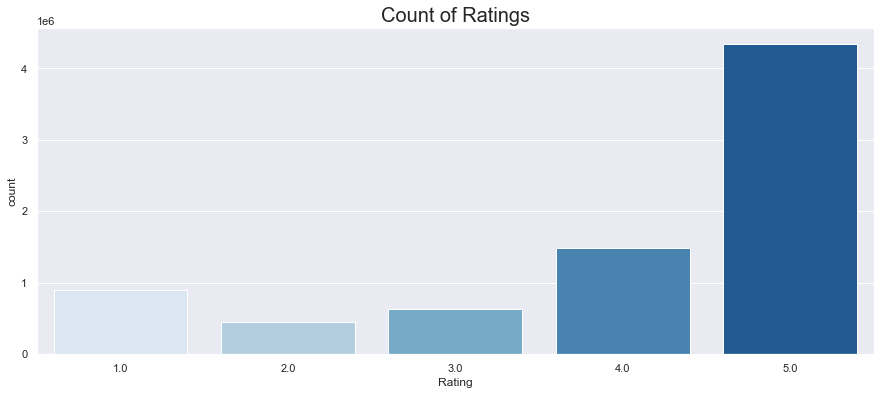

In [6]:
plt.figure(figsize=(15,6))
sns.countplot(data = df, x = 'Rating', palette = 'Blues')
plt.title('Count of Ratings',fontdict={'fontsize':20});

## Total Number of Ratings per User
### Here we observe the number of ratings given by each user. It seems that up until the 75th percentile of users only gave a single rating to products and the maximum rating given by a single user was 103.

In [7]:
df.groupby('User ID').count().describe()

Product ID        Rating          Date
count  4.201696e+06  4.201696e+06  4.201696e+06
mean   1.862220e+00  1.862220e+00  1.862220e+00
std    2.885110e+00  2.885110e+00  2.885110e+00
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    1.000000e+00  1.000000e+00  1.000000e+00
50%    1.000000e+00  1.000000e+00  1.000000e+00
75%    2.000000e+00  2.000000e+00  2.000000e+00
max    5.200000e+02  5.200000e+02  5.200000e+02

## Percentage of Number of Ratings Given
### We have seen that most products received either a 5 star or 4 star review. But out of all products reveiwed, what do the percentages of these look like? How many received a 5 star review out of the total number of products reveiwed.

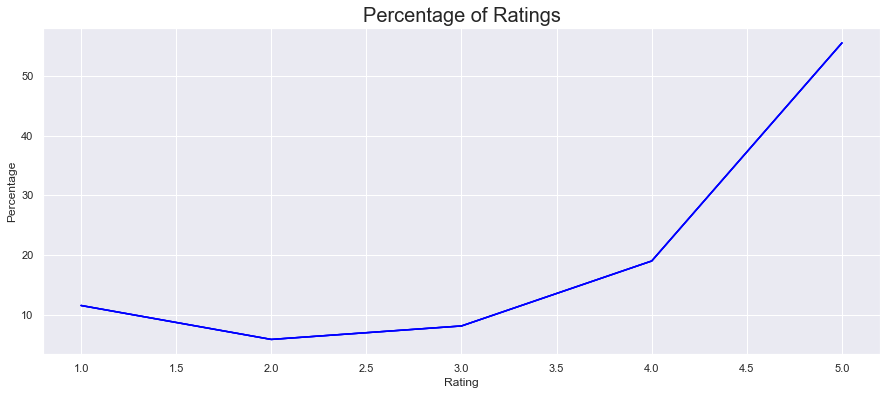

In [8]:
plt.figure(figsize=(15,6))
plt.plot((df.groupby('Rating').count()/df.shape[0])*100, color='blue')
plt.title('Percentage of Ratings', fontdict={'fontsize':20})
plt.xlabel('Rating')
plt.ylabel('Percentage');

### It seems that more than 50% of products received a 5 star review and another 20% received a 4 star review. We can now accurately conclude that atleast 70% of the products reviewed were of high quality, or at least left the user satisfied.

### Let's look at the ratings in more depth. Let's see the number of times a product was rated and then the average rating given to these products.

In [9]:
df.groupby('Product ID')['Rating'].count().sort_values(ascending=False)

Product ID
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B004WL91KI        1
B004WL9FK4        1
B004WL9Q2Q        1
B004WL9R8O        1
BT008V9J9U        1
Name: Rating, Length: 476002, dtype: int64

### Since the maximum number of times any given product was rated is 2547. A bin size of 50 would be fair which will give us 50 items in each bar of the histogram we will plot

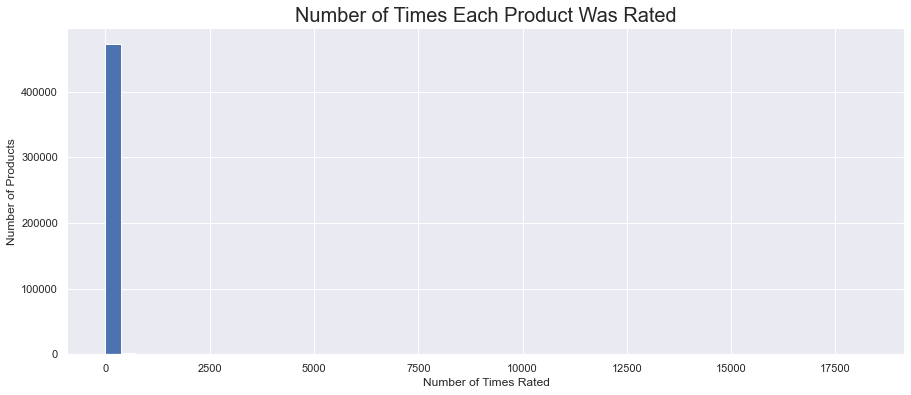

In [10]:
plt.figure(figsize=(15,6))
df.groupby('Product ID')['Rating'].count().hist(bins=50)
plt.title('Number of Times Each Product Was Rated', fontdict={'fontsize':'20'})
plt.xlabel('Number of Times Rated')
plt.ylabel('Number of Products');

### The above histogram shows that an absurd amount of products were rated less than 50 times. To cater for this skewness, let's only consider getting average rating of products which are rated more than 50 times.

In [11]:
# Only including those users which gave more than 50 readings
new_df = df.groupby('Product ID').filter(lambda x:x['Rating'].count() >= 50)

In [12]:
new_df_rating_count = pd.DataFrame(new_df.groupby('Product ID')['Rating'].mean())
new_df_rating_count['Count'] = new_df.groupby('Product ID')['Rating'].count()
new_df_rating_count

Rating  Count
Product ID                 
0972683275  4.470980   1051
1400501466  3.560000    250
1400501520  4.243902     82
1400501776  3.884892    139
1400532620  3.684211    171
...              ...    ...
B00KFAGCUM  4.824427    131
B00KGGJPX6  4.592593     54
B00KINSDK8  3.576923     52
B00KWHMR6G  3.637931     58
B00L3YHF6O  4.814286     70

[26226 rows x 2 columns]

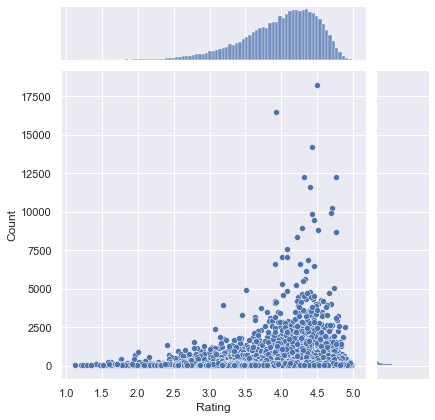

In [13]:
sns.jointplot('Rating','Count',data=new_df_rating_count);

### This figure represents the average rating given to a product (which was reviewed at least 50 times or more) and the number of times it was rated. If we split the graph into 4 equal hypothetical quartiles, the top right quartile will represent the highest quality products and the lower left quartile will represent the lowest quality products.

## Time Series Visualizations

In [14]:
#Set the time stamp as the index
df.reset_index(drop=True,inplace=True)
df.sort_values('Date', ascending=True,inplace=True)
df.set_index('Date',inplace=True)
df.head()

User ID  Product ID  Rating
Date                                          
1998-12-04  A2ZUNCI13N2OUL  B00000DM9D     4.0
1998-12-07  A28AXJL31RXUON  B00000DM9M     4.0
1998-12-18   AFHLJPG5ZIMNO  B00000DM96     5.0
1998-12-26   AY2NE9ZEZ5LCE  B00000DM9D     5.0
1999-05-02  A2LG0LV5RI86F0  B00000DM93     5.0

### For ease of visualizations lets take orders from 2006 onwards

In [15]:
df_timeseries = df.loc['2006-01-01':]
df_timeseries

User ID  Product ID  Rating
Date                                          
2006-01-01  A17JQIGHZCK73L  B00004Y2ZF     4.0
2006-01-01  A2P3HVA3WXYMSP  B0002GRQTA     5.0
2006-01-01  A22ZEGWI4XJEQK  B000CCBFF0     3.0
2006-01-01  A131EK7QBO1PBE  B000AYKUUQ     4.0
2006-01-01  A3E5DOAY5VUB1E  B0002YE6EK     5.0
...                    ...         ...     ...
2014-07-23   A73N4TGUPZV7V  B00JCE14AU     5.0
2014-07-23  A2BIIQLXDW8MR5  B00IVPU786     5.0
2014-07-23  A1VLZLIRXU73WQ  B00GU9UG9A     1.0
2014-07-23   A7DQOAV170BS0  B0009VU7TO     5.0
2014-07-23  A2QC7Y7P399NYY  B00IA9LQK6     5.0

[7669978 rows x 3 columns]

### We can already begin to see that there are gaps in the dates. We do not have data for all days of the months.

## How the number of orders have changed throughout the years

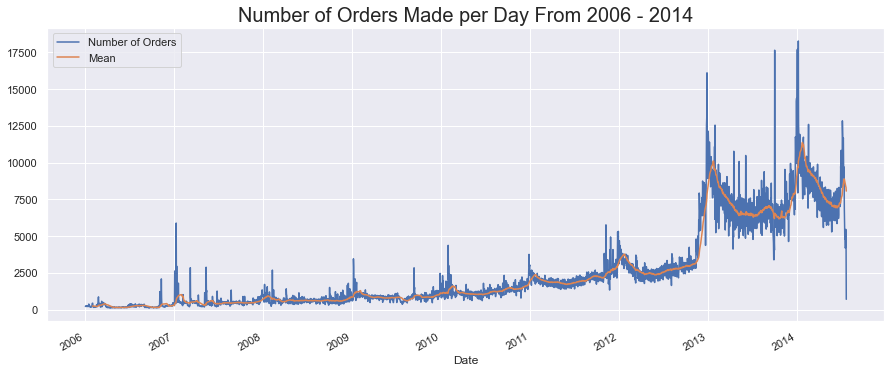

In [16]:
df_timeseries.groupby('Date')['User ID'].count()
plt.figure(figsize=(15,6))
plt.plot(df_timeseries.groupby('Date')['User ID'].count())
df_timeseries.groupby('Date')['User ID'].count().rolling(window=30).mean().plot()
plt.title('Number of Orders Made per Day From 2006 - 2014', fontdict={'fontsize':20})
plt.legend(['Number of Orders','Mean']);

### The number of daily orders have remained fairly consistent through the beginning of the 21st century and saw an exponential increase in 2013 after which it kept seeing a spike at the beginning of the year.

In [17]:
#Creating month and year column
df_timeseries['Month'] = df_timeseries.index.month
df_timeseries['Year'] = df_timeseries.index.year

### How many products are ordered throughout the week. Are there a higher number of orders on the weekends?
### For ease, we will only consider this for the year 2013. The below graph looks at the daily number of orders throughout the year

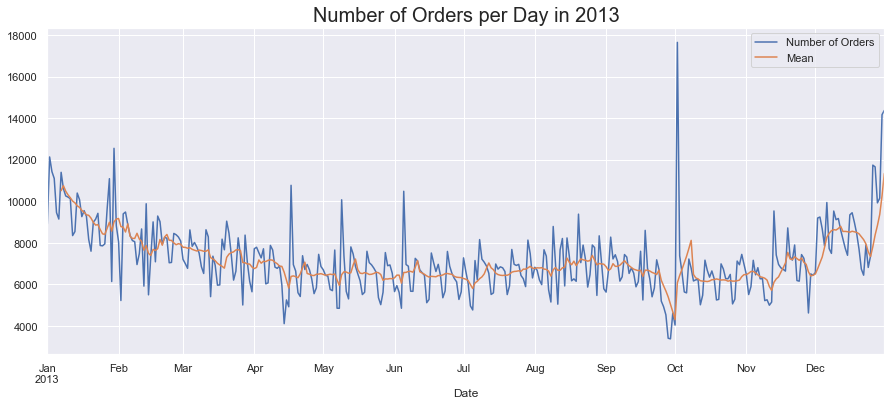

In [18]:
# Grabbing values for only 2013
df_timeseries_2013 = df_timeseries[df_timeseries.index.year == 2013]

plt.figure(figsize=(15,6))
df_timeseries_2013.groupby('Date')['User ID'].count().plot()
df_timeseries_2013.groupby('Date')['User ID'].count().rolling(window=7).mean().plot()
plt.title('Number of Orders per Day in 2013', fontdict={'fontsize':20})
plt.legend(['Number of Orders','Mean']);

### Looking at the 2013 data, we can confirm the highest mean number of orders we get is around January and December. There seems to be a peak in October but that can be just taken as an outlier.
### Now lets break this down to a weekly level and see how it looks for each month

    Month  Day of Week Day of Week Name  User ID  Product ID  Rating   Year
0       1            0              Mon    41885       41885   41885  41885
1       1            1              Tue    44888       44888   44888  44888
2       1            2              Wed    53635       53635   53635  53635
3       1            3            Thurs    47890       47890   47890  47890
4       1            4              Fri    38373       38373   38373  38373
..    ...          ...              ...      ...         ...     ...    ...
79     12            2              Wed    34188       34188   34188  34188
80     12            3            Thurs    36664       36664   36664  36664
81     12            4              Fri    37478       37478   37478  37478
82     12            5              Sat    32143       32143   32143  32143
83     12            6              Sun    38075       38075   38075  38075

[84 rows x 7 columns]


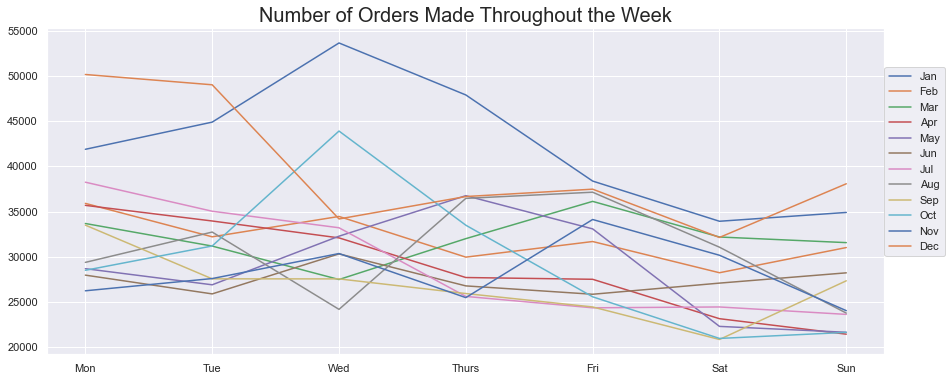

In [19]:
# Getting day of week
df_timeseries_2013['Day of Week'] = df_timeseries_2013.index.weekday
df_timeseries_2013['Day of Week Name'] = df_timeseries_2013['Day of Week']

# Converting day of week numbers to names
df_timeseries_2013['Day of Week Name'] = df_timeseries_2013['Day of Week Name'].replace([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thurs','Fri','Sat','Sun'])

# Grouping to get the number of orders in a week per month of 2013
df_timeseries_2013_grouped = df_timeseries_2013.groupby(['Month','Day of Week','Day of Week Name']).count().reset_index()
df_timeseries_2013_grouped = df_timeseries_2013_grouped.sort_index(level='Day of Week')
print(df_timeseries_2013_grouped)

#Plotting number of orders in a week for 2013
plt.figure(figsize=(15,6))
for i in df_timeseries_2013_grouped['Month'].unique():
    plt.plot('User ID', data = df_timeseries_2013_grouped[df_timeseries_2013_grouped['Month'] == i].set_index('Day of Week Name'))

plt.title('Number of Orders Made Throughout the Week', fontdict={'fontsize':20})
plt.legend(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], loc=(1,0.3));

### January far exceeds all other months in terms of number of orders made. This confirms our previous hypothesis of orders being higher during the ending and starting period of the year.

# Building a Recommendation System using Machine Learning

### In this section we will look at 4 ML algorithms. Normal Predictor, SVD, KNN with means, Slope One, and compare each of them on the accuracy of their predictions and computational time.

### These algorithms are chosen on the basis of their popularity of use in building recommendation systems as well as my current knowledge on how well I understand each of them.

### For simplicity we will be taking 2 assumptions:
### 1. The accuracy measure we will be using for all will be RMSE which is one of the most widely used offline accuracy measure for recommendation systems
### 2. Each algorithm will be evaluated with using cross validation of 5 folds
### 3. Where parameter tuning is applicable, a set of the data will be used for grid search to find the optimal parameters of the algorithm and another set of the data for accuracy measurment. This prevents biased accuracy measurment where the same set of data is used for both parameter tuning and measuring accuracy of predictions.
### 4. For splitting data into 2 sets for grid search, 90% of the data will be for parameter tuning and 10% for unbiased accuracy measurment

# Normal Predictor

### This is a very basic algorithm which predicts a random rating of an item based on the distribution of the dataset which is assumed to be normal. This is taken as a baseline of sorts so we can see the accuracy we get from a very basic algorithm and how more commonly used and comlpicated algorithms fare in comparison.

In [20]:
#Importing Libraries
import datetime
from surprise import SVD
from surprise import SlopeOne
from surprise import KNNWithMeans
from surprise import NormalPredictor
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [21]:
#Showing a preview of the data frame
data = df.reset_index(drop=True)
data.head()

User ID  Product ID  Rating
0  A2ZUNCI13N2OUL  B00000DM9D     4.0
1  A28AXJL31RXUON  B00000DM9M     4.0
2   AFHLJPG5ZIMNO  B00000DM96     5.0
3   AY2NE9ZEZ5LCE  B00000DM9D     5.0
4  A2LG0LV5RI86F0  B00000DM93     5.0

In [22]:
#Reading and preparing the data
data = df.reset_index(drop=True)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data,reader)

#Start time
start_time = datetime.datetime.now()

#Running K Fold Cross Validation
cross_validate(NormalPredictor(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

#End time
end_time = datetime.datetime.now()
print('\nTotal time taken: \n', end_time - start_time)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7679  1.7665  1.7670  1.7673  1.7679  1.7673  0.0005  
MAE (testset)     1.3567  1.3554  1.3554  1.3561  1.3570  1.3561  0.0007  
Fit time          12.91   16.65   17.39   18.05   17.36   16.47   1.83    
Test time         16.73   22.60   15.44   14.40   17.28   17.29   2.84    

Total time taken: 
 0:06:06.948761


### A mean RMSE of 1.7385 means that our predictions are off quite a bit considering our ratings only range from 1 to 5. But considering the simplicity of the algorithm this is quite a good accuracy to have. 

# Singular Value Decomposition

### Popularized by Simon Funk during the NETFLIX prize, SVD comes under the Matrix Decomposition family of algorithms. This is considered quite a complex algorithm with many different parameters to tune it. Parameter tuning is applicable here so we will use 2 seperate sets of data. One for parameter tuning and another for unbiased accuracy measure as stated previously.

### For sake of simplicity (and my poor laptops computational resources), we will only tune the number of epochs and learning rate parameters and use the RMSE accuracy measure.

### In the intrest of saving computational time, I have tried multiple grid search tests and came up with the parameters which shows the best accuracies using 100,000 rows of data and will use those resulting parameters for the full dataset.

In [23]:
#Reading and preparing the data
data = df.reset_index(drop=True)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data,reader)
raw_ratings = data.raw_ratings

#Saving 2 different sets of data for un-biased accuracy estimations
threshold = int(0.9 * len(raw_ratings))
raw_ratings_A = raw_ratings[:threshold]
raw_ratings_B = raw_ratings[threshold:]
data.raw_ratings = raw_ratings_A

#Start time
start_time = datetime.datetime.now()

#Selecting the best parameters using grid search
param_grid = {'n_epochs':[22],'lr_all':[0.010]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
grid_search.fit(data)
print('Best parameters: ', grid_search.best_params)

algo = grid_search.best_estimator['rmse']    #Creates an algorithm instance with the best parameters so we can use it directly

#Training dataset A on the model
trainset = data.build_full_trainset()
algo.fit(trainset)

#Computing a biased accuracy score
pred_A = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(pred_A)

#Compute unbiased accuracy on B
testset = data.construct_testset(raw_ratings_B)
pred_B = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(pred_B)

#End time
end_time = datetime.datetime.now()
print('\nTime taken: ', end_time - start_time)


Best parameters:  {'rmse': {'n_epochs': 22, 'lr_all': 0.01}}
Biased accuracy on A,   RMSE: 0.3570
Unbiased accuracy on B, RMSE: 1.3117

Time taken:  1:01:23.566335


# K Nearest Neighbours

### This comes under the Clustering family of algorithms where it finds the nearest neighbours to a user using a specified similarity metric such as Cosine similarity, Mean Squared Difference, and Pearson correlation to name some of the more well known ones. In our case, we will be using the cosine similarity metric.

### Parameter tuning is applicable here as well so specific parameter we will look at are 'k' (the number of neighbours), 'Similarity Metric' (we are going with cosine only), 'User or Item Based' (we will go with user based), 'Minimum Support' (this is the minimum number of neighbours a user must have to be included in the algorithm)

### The trouble we have here is that since the matrices computed here are so large, my laptop runs out of memory and so we can only do a limited number of experiments. We will only be experimenting with 3 different values of 'k'.

### In the intrest of saving computational time, I have tried multiple grid search tests and came up with the parameters which shows the best accuracies using 100,000 rows of data and will use those resulting parameters for the full dataset.

In [46]:
#Reading and preparing the data
data = df.reset_index(drop=True)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data,reader)
raw_ratings = data.raw_ratings

#Saving 2 different sets of data for un-biased accuracy estimations
threshold = int(0.9 * len(raw_ratings))
raw_ratings_A = raw_ratings[:threshold]
raw_ratings_B = raw_ratings[threshold:]
data.raw_ratings = raw_ratings_A

#Start Time
start_time = datetime.datetime.now()

param_grid = {'k':[40],'sim_options':{'name':['cosine'],'user_based':[True],'min_support':[35]}}
grid_knn = GridSearchCV(KNNWithMeans,param_grid,measures=['rmse'],cv=5)
grid_knn.fit(data)
print('\nBest parameters: \n', grid_knn.best_params)

algo_knn = grid_knn.best_estimator['rmse']    #Creates an algorithm instance with the best parameters so we can use it directly

#Training dataset A on the model
trainset = data.build_full_trainset()
algo.fit(trainset)

#Computing a biased accuracy score
pred_A = algo.test(trainset.build_testset())
print('\nBiased accuracy on A,', end='   ')
accuracy.rmse(pred_A)

#Compute unbiased accuracy on B
testset = data.construct_testset(raw_ratings_B)
pred_B = algo.test(testset)
print('\nUnbiased accuracy on B,', end=' ')
accuracy.rmse(pred_B)

#End time
end_time = datetime.datetime.now()
print('\nTime taken: \n',end_time - start_time)

Computing the cosine similarity matrix...


MemoryError: Unable to allocate 24.5 GiB for an array with shape (57291, 57291) and data type float64

In [40]:
data = df.iloc[0:1000000].reset_index(drop=True)
data.head()

User ID  Product ID  Rating
0  A2ZUNCI13N2OUL  B00000DM9D     4.0
1  A28AXJL31RXUON  B00000DM9M     4.0
2   AFHLJPG5ZIMNO  B00000DM96     5.0
3   AY2NE9ZEZ5LCE  B00000DM9D     5.0
4  A2LG0LV5RI86F0  B00000DM93     5.0

# Slope One

### Slope One is another simple but effective algorithm. To explain simply, it takes a commonly rated item between a pair of users (lets call them A and B) and calculates a difference in rating between them. It then computes a predicted rating for an item for B for which the user A has already given a rating. Simple yet effective.

In [ ]:
#Reading and preparing the data
data = df.reset_index(drop=True)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(data,reader)

#Start time
start_time = datetime.datetime.now()

#Running K Fold Cross Validation
cross_validate(SlopeOne(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

#End time
end_time = datetime.datetime.now()
print('\nTime taken: \n',end_time - start_time)